In [1]:
from os.path import dirname, abspath
from os.path import join
import PIL
from PIL.Image import open, new, fromarray
from PIL.ImageOps import expand
from matplotlib.pyplot import savefig, imshow, set_cmap
import matplotlib.pyplot as plt
import numpy as np

from numpy import linalg as LA

# Load CBCL Faces Dataset

In [2]:
import scipy.io

mat = scipy.io.loadmat('./X.mat')
print(mat['X'].shape)
dataset = mat['X']
print(dataset.shape)


(2429, 361)
(2429, 361)


## Visualize some faces

In [3]:
def visualize(faces):
    n = 16
    fig, axs = plt.subplots(n, n, figsize=(19, 19))
    for i in range(n*n):
        ax = axs[i//n, i%n]
        ax.imshow(faces[i,:].reshape(19, 19).T, cmap='gray')
        ax.axis('off')

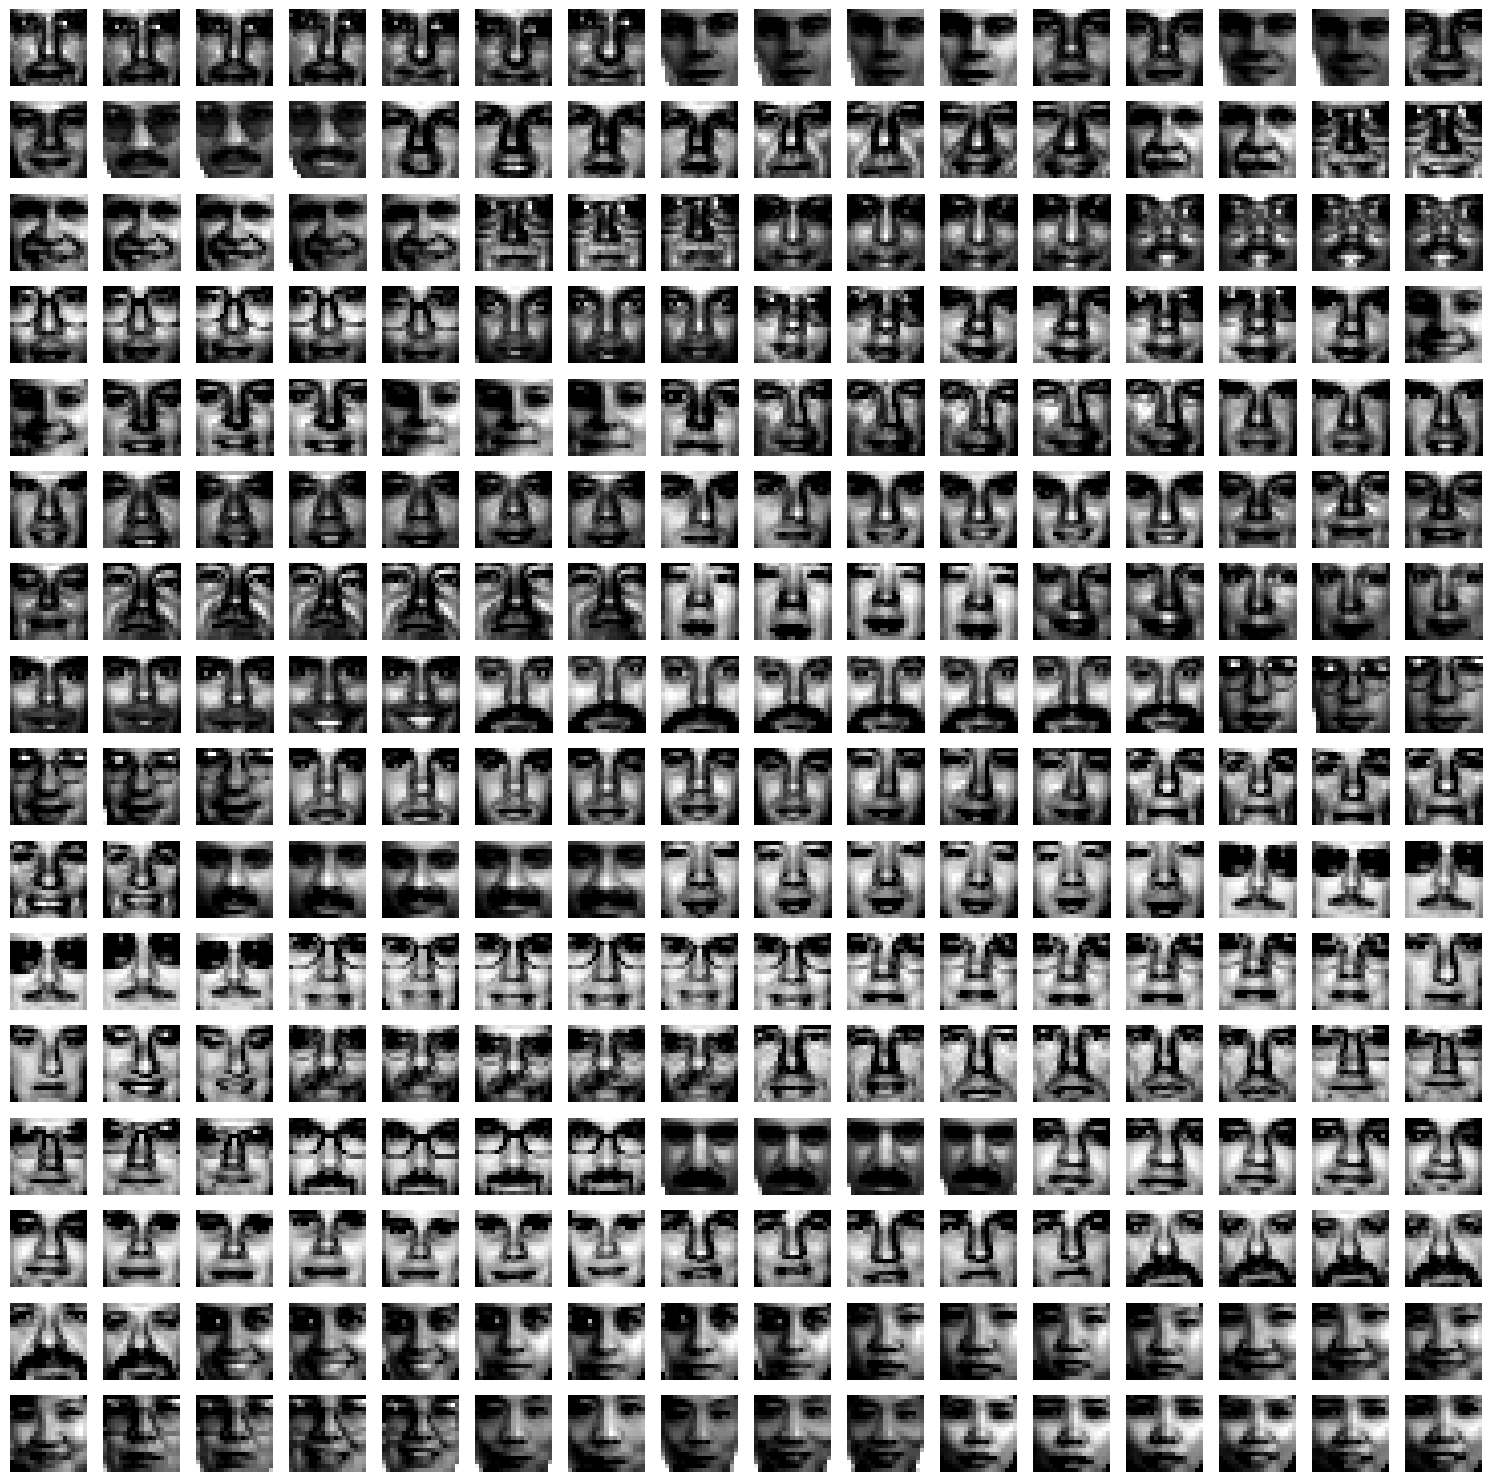

In [4]:
visualize(dataset)

In [7]:
def NMF(A):
    nr_iterations = 500     # choose good number of iterations (large -> better convergence)
    alpha = 1.0             # step scaling; if unstable reduce to 0.5 or 0.2
    r = 100                 # rank of factorization

    # initialize W and H
    np.random.seed(42)  # optional reproducibility
    W = np.random.uniform(size=(A.shape[0], r), low=0.0, high=1.0)
    H = np.random.uniform(size=(r, A.shape[1]), low=0.0, high=1.0)

    eps = 1e-8  # numerical stability

    for i in range(nr_iterations):
        # print error occasionally (printing every iter is slow)
        if i % 10 == 0 or i == nr_iterations - 1:
            print(f"iteration {i}, error: {LA.norm(A - W @ H):.6f}")

        # gradients for ||A - W H||_F^2   (factor 2 absorbed into step sizes)
        grad_W = W @ (H @ H.T) - A @ H.T
        grad_H = (W.T @ W) @ H - W.T @ A

        # Lipschitz-based step sizes (stable)
        L_W = max(eps, LA.norm(H @ H.T, ord=2))
        L_H = max(eps, LA.norm(W.T @ W, ord=2))

        eta_W = alpha / L_W
        eta_H = alpha / L_H

        # projected gradient step (enforce non-negativity)
        W_next = np.maximum(0.0, W - eta_W * grad_W)
        H_next = np.maximum(0.0, H - eta_H * grad_H)

        # ✅ the correct update line (no stray 'W'!)
        W, H = W_next, H_next

    return W, H



In [8]:
W,H = NMF(dataset)

iteration 0, error: 23382.348238
iteration 10, error: 163.274738
iteration 20, error: 142.355402
iteration 30, error: 122.262302
iteration 40, error: 110.529686
iteration 50, error: 102.438695
iteration 60, error: 96.367391
iteration 70, error: 91.516997
iteration 80, error: 87.512037
iteration 90, error: 84.157369
iteration 100, error: 81.308506
iteration 110, error: 78.849736
iteration 120, error: 76.712654
iteration 130, error: 74.848945
iteration 140, error: 73.216204
iteration 150, error: 71.774903
iteration 160, error: 70.497386
iteration 170, error: 69.356263
iteration 180, error: 68.331474
iteration 190, error: 67.408866
iteration 200, error: 66.574269
iteration 210, error: 65.813764
iteration 220, error: 65.116896
iteration 230, error: 64.476444
iteration 240, error: 63.886493
iteration 250, error: 63.341775
iteration 260, error: 62.835934
iteration 270, error: 62.365123
iteration 280, error: 61.925174
iteration 290, error: 61.512473
iteration 300, error: 61.123876
iteration 3

In [9]:
print(f"W.shape = {W.shape}, H.shape = {H.shape}")

W.shape = (2429, 100), H.shape = (100, 361)


## Face parts

The matrix H consists after optimization of face parts and each face in the dataset is a positive combination of those.

Let us visualize some entries of H.

In [12]:
def visualize(faces):
    n = 16
    fig, axs = plt.subplots(n, n, figsize=(19, 19))
    total = min(n*n, faces.shape[0])  # avoid out-of-bounds

    for i in range(total):
        ax = axs[i//n, i % n]
        ax.imshow(faces[i, :].reshape(19, 19).T, cmap='gray')
        ax.axis('off')

    # turn off remaining axes
    for i in range(total, n*n):
        ax = axs[i//n, i % n]
        ax.axis('off')

    plt.tight_layout()


<module 'matplotlib.pyplot' from 'C:\\Users\\t00002k9\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

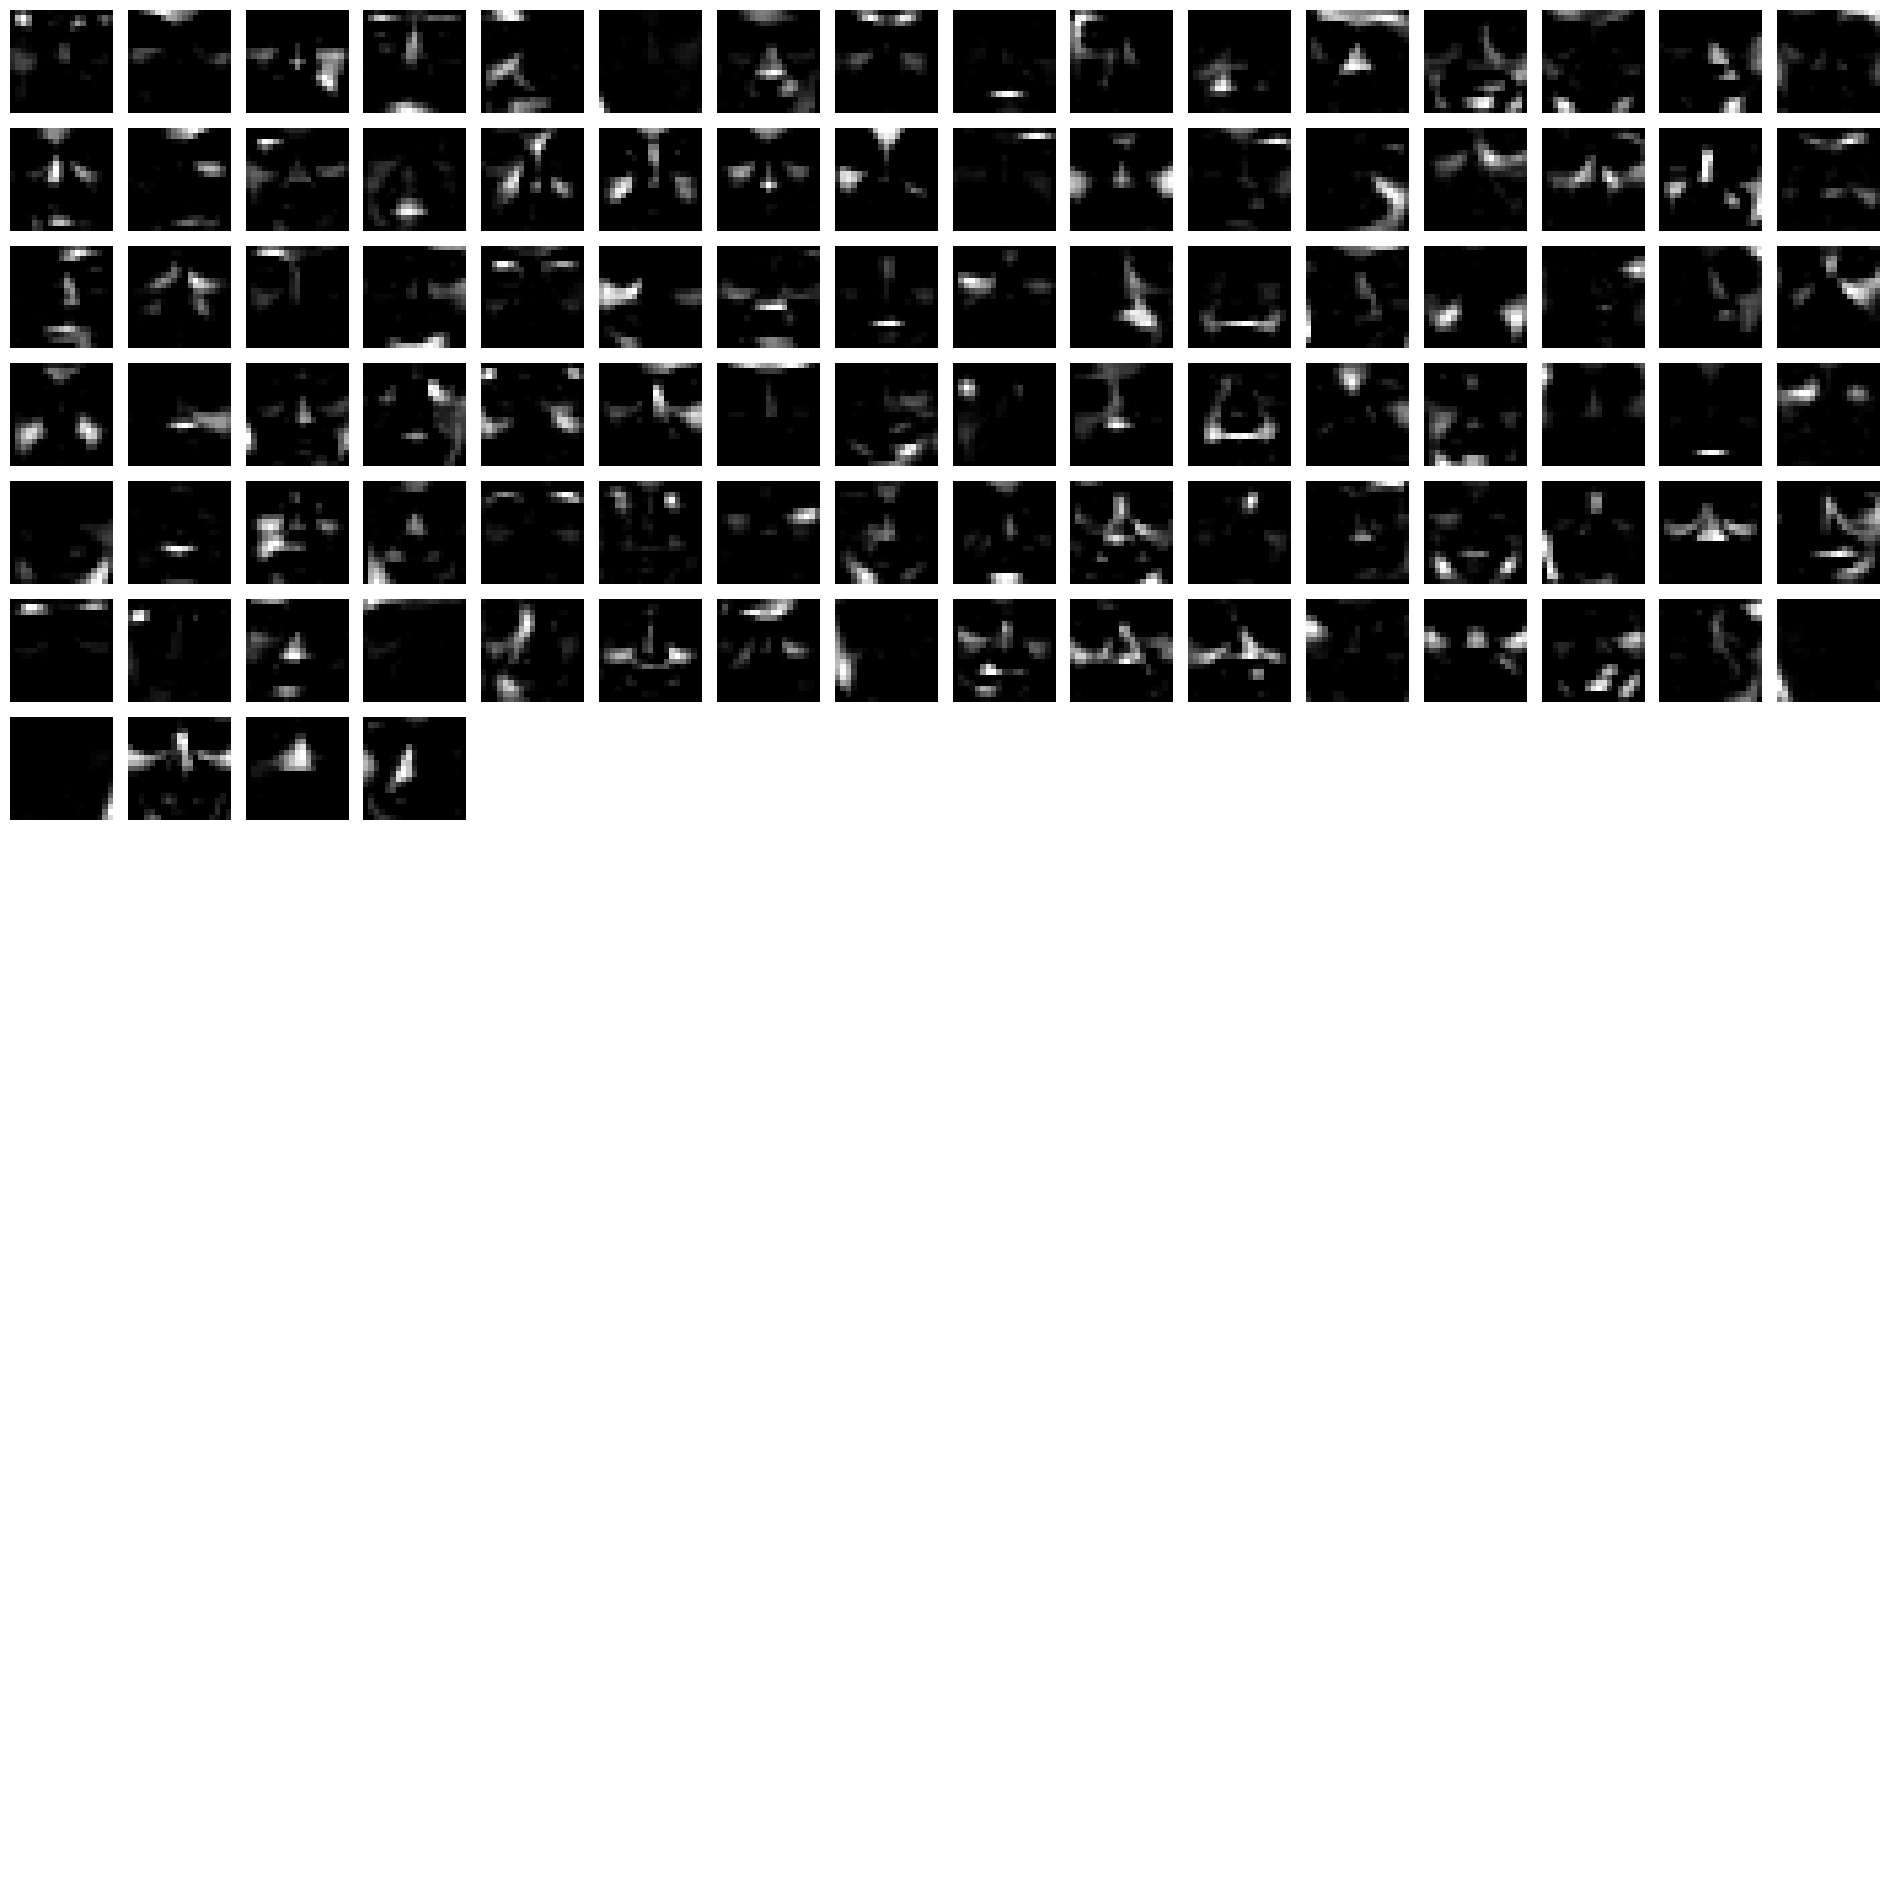

In [14]:
visualize(H)
plt


## Reconstruction

Let us reconstruct the first face in the dataset given the NMF.

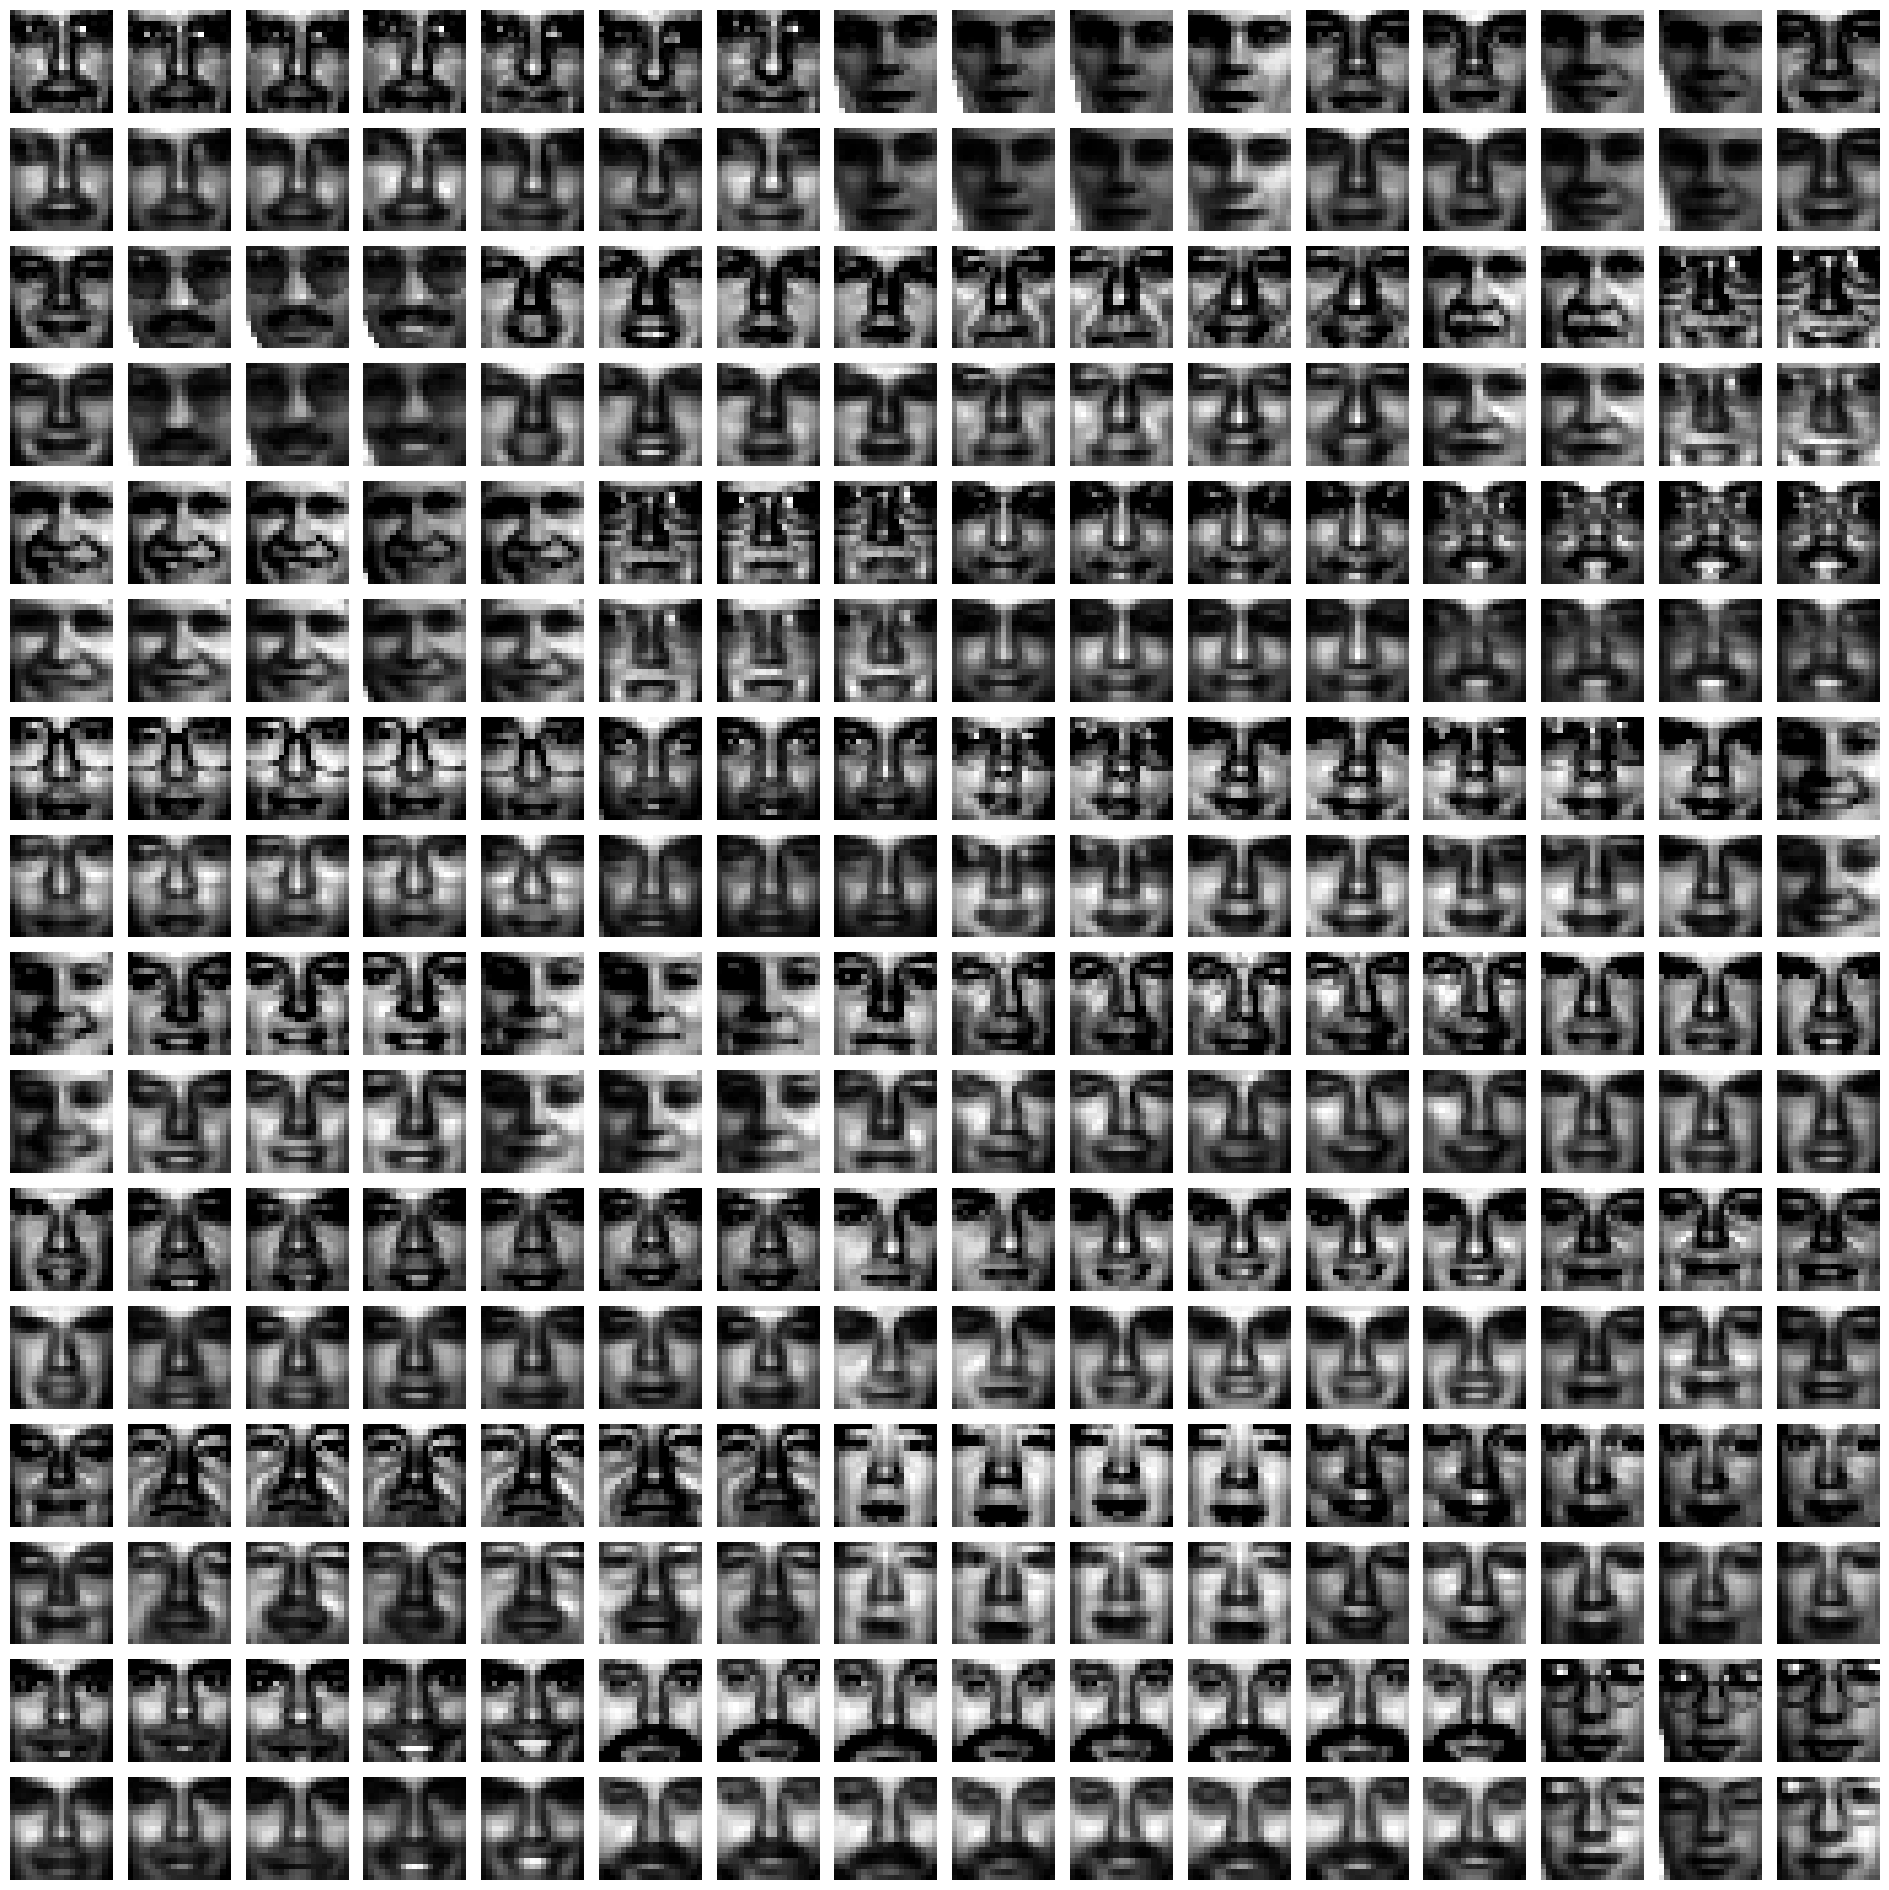

In [16]:

# Reconstruction
# Let us reconstruct the first face in the dataset given the NMF.
n = 16
fig, axs = plt.subplots(n, n, figsize=(19, 19))

for i in range(n*(n//2)):
    face = dataset[i,:].reshape(19, 19).T
    recon = (W[i,:] @ H).reshape(19, 19).T

    ax = axs[i//n * 2, i%(n)]
    ax.imshow(face, cmap='gray')
    ax.axis('off')

    ax = axs[i//n * 2 + 1, i%(n)]
    ax.imshow(recon, cmap='gray')
    ax.axis('off')

plt.tight_layout()
